In [ ]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Lesson: Deep Learning Regression Tutorial
#
# Description: Training Linear Regression with Keras 3 API
#    """
#    Project Description:
#    ------------------
#    This notebook demonstrates how to build a deep learning regression model using TensorFlow/Keras.
#    We'll generate synthetic data using scikit-learn, then build, train, and evaluate a neural network
#    for regression tasks. This tutorial is designed for educational purposes to help understand the
#    complete workflow of creating deep learning models for regression problems.
#
#    Objectives:
#    ----------
#    1. Learn how to generate synthetic regression data
#    2. Understand deep learning model architecture for regression
#    3. Learn the proper steps for data preprocessing
#    4. Build and compile a neural network using Keras
#    5. Train and evaluate the model's performance
#    6. Visualize the results and model predictions
#    """
# =======================================================================
#.          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [1]:
# 1. Environment Setup
# ------------------
import os  
import sys 
from pathlib import Path
from pprint import pprint

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam


print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

Author: Dr. Saad Laouadi

Last updated: 2024-12-07

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
numpy     : 1.26.4
tensorflow: 2.16.2
matplotlib: 3.9.2
sys       : 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]
pandas    : 2.2.2
sklearn   : 1.5.1
keras     : 3.6.0



In [2]:
# 2. Data Generation Function
# -------------------------
def generate_regression_data(n_samples=1000, n_features=1, noise=20.0, random_state=42):
    """
    Generate synthetic regression data using sklearn's make_regression.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features (independent variables)
    noise : float
        Standard deviation of gaussian noise
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        Generated samples
    y : ndarray of shape (n_samples,)
        Target values
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    # Reshape y to be a column vector
    y = y.reshape(-1, 1)
    
    return X, y


# Normalize the data
def normalize_data(df):
    """
    Normalize the features and target using StandardScaler.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing features and target
    
    Returns:
    --------
    X_scaled : numpy array
        Normalized features
    y_scaled : numpy array
        Normalized target
    scalers : tuple
        (X_scaler, y_scaler) for inverse transformation if needed
    """
    # Separate features and target
    X_data = df.drop('Y', axis=1)
    y_data = df['Y']
    
    # Create scalers
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Fit and transform the data
    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, (X_scaler, y_scaler)


def normalize_features_split(X_train, X_test):
    """
    Normalize features using StandardScaler after splitting.
    Fits on training data and transforms both training and test data.
    
    Parameters:
    -----------
    X_train : numpy array or DataFrame
        Training features
    X_test : numpy array or DataFrame
        Test features
    
    Returns:
    --------
    X_train_scaled : numpy array
        Normalized training features
    X_test_scaled : numpy array
        Normalized test features
    scaler : StandardScaler
        Fitted scaler for future transformations
    """
    # Create scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform test data using training fit
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

In [3]:
# Generate random data
X, y = generate_regression_data(n_samples=10000, n_features=3, random_state=101)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (10000, 3)
Target shape: (10000, 1)


In [4]:
# Check the data description 
df = pd.DataFrame(data = np.concatenate([X, y], axis = 1),
                  columns = [f"X_{i}" for i in range(1,4)]+['Y']
                 )

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,10000.0,-0.001262,0.994194,-3.806886,-0.674393,0.001271,0.676238,4.155123
X_2,10000.0,-0.004265,1.007255,-3.756504,-0.680627,-0.008693,0.678417,4.651961
X_3,10000.0,0.006563,0.996595,-3.919881,-0.665755,0.005914,0.666455,4.260621
Y,10000.0,0.453045,110.003277,-444.537202,-74.224674,-0.384304,74.285186,403.351975


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=101
)

print(f"The X train set shape: {X_train.shape}")
print(f"The X test set shape: {X_test.shape}")
print(f"The y train set shape: {y_train.shape}")
print(f"The y test set shape: {y_test.shape}")

The X train set shape: (8000, 3)
The X test set shape: (2000, 3)
The y train set shape: (8000, 1)
The y test set shape: (2000, 1)


In [ ]:
# Scale the data

In [7]:
# Apply normalization to our split data
X_train_scaled, X_test_scaled, scaler = normalize_features_split(X_train, X_test)

# Verify the scaling
print("\nTraining set after scaling:")
print("X_train mean ≈ 0:", np.mean(X_train_scaled, axis=0))
print("X_train std ≈ 1:", np.std(X_train_scaled, axis=0))

print("\nTest set after scaling:")
print("X_test mean:", np.mean(X_test_scaled, axis=0))
print("X_test std:", np.std(X_test_scaled, axis=0))

print("\nTarget range (original scale):")
print("y_train min:", np.min(y_train))
print("y_train max:", np.max(y_train))
print("y_test min:", np.min(y_test))
print("y_test max:", np.max(y_test))


Training set after scaling:
X_train mean ≈ 0: [-4.34652314e-17  1.20771448e-17  5.88244731e-17]
X_train std ≈ 1: [1. 1. 1.]

Test set after scaling:
X_test mean: [-0.02600709 -0.00427045  0.0303087 ]
X_test std: [0.96583745 1.00918243 1.00488431]

Target range (original scale):
y_train min: -444.53720168135914
y_train max: 403.35197543963017
y_test min: -373.28898902886084
y_test max: 402.2616588583003


In [8]:
# Create the Neural Network Model
# ------------------------------

"""
Step-by-step building of a neural network for regression using the add() method.
This tutorial assumes we have our scaled data: X_train_scaled, X_test_scaled, y_train, y_test
"""

# 1. Create an empty sequential model
model = Sequential(name = "RegressionModel")
print(model.summary())

Model: "RegressionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
input_shape = X_train.shape[1]             # Number of input features

# 2. Add the Input layer first 
model.add(Input(shape=(input_shape,), name='The_Input_Layer'))

In [10]:
# Check the model specifications
print("*"*80)
print("The model Configuration".center(80))
print("*"*80)
pprint(model.get_config())

print("The model Weights".center(80))
print("*"*80)

pprint(model.get_weights())

********************************************************************************
                            The model Configuration                             
********************************************************************************
{'dtype': {'class_name': 'DTypePolicy',
           'config': {'name': 'float32'},
           'module': 'keras',
           'registered_name': None},
 'layers': [{'class_name': 'InputLayer',
             'config': {'batch_shape': (None, 3),
                        'dtype': 'float32',
                        'name': 'The_Input_Layer',
                        'sparse': False},
             'module': 'keras.layers',
             'registered_name': None}],
 'name': 'RegressionModel',
 'trainable': True}
                               The model Weights                                
********************************************************************************
[]


In [11]:
# 3. Add the Input Layer
#     The first layer needs to know the input shape (number of features)
#     units=64 means 64 neurons in this layer
#    'relu' is a common activation function that helps the model learn non-linear patterns

model.add(Dense(
    units=64,                                  # Number of neurons in this layer
    activation='relu',                         # Activation function
    name='The_First_Hidden_Layer'                     # Name to identify the layer
))

In [12]:
print("The model Weights".center(80))
print("*"*80)

pprint(model.get_weights())

print("-"*80)
print("The weights shape:", model.get_weights()[0].shape)
print("The bias shape:", model.get_weights()[1].shape)
print("*"*80)

                               The model Weights                                
********************************************************************************
[array([[-0.11280735, -0.13879536,  0.16822976,  0.12404272, -0.24914044,
         0.2117315 ,  0.1870569 ,  0.22267944,  0.03220436,  0.05517498,
        -0.00310296, -0.00585634, -0.26920292, -0.2403498 ,  0.14465985,
         0.2829681 , -0.2358036 , -0.12675905,  0.24151355,  0.12127501,
        -0.00625318, -0.2693407 ,  0.05230916,  0.0861299 ,  0.08024824,
        -0.07896712,  0.21467185,  0.07611108, -0.05958052, -0.04633966,
         0.27798736, -0.15363398,  0.29513872,  0.25451595, -0.20359781,
        -0.2632188 , -0.24357413, -0.15333582,  0.17766744, -0.18323539,
         0.14830318, -0.22019386,  0.03893986, -0.16444726,  0.14514035,
        -0.20740092, -0.14966694,  0.13421413, -0.14968306, -0.24666925,
         0.08765739,  0.17244789,  0.22984225,  0.01681858,  0.15537244,
         0.16358894, -0.08942002, 

In [13]:
# 4. Add First Hidden Layer
# This layer gets its input shape automatically from the previous layer
model.add(Dense(
    units=32,                           # Number of neurons (smaller than previous layer)
    activation='relu',                  # Same activation as before
    name='hidden_layer_2'               # Name for identification
))

In [14]:
# 5. Add Third Hidden Layer
# Making the network "deeper" by adding another layer
model.add(Dense(
    units=16,                         # Even fewer neurons
    activation='relu',                # Same activation
    name='hidden_layer_3'            # Name for identification
))

In [15]:
# 6. Add Output Layer
# For regression, we use 1 neuron and no activation function
model.add(Dense(
    units=1,                           # One neuron for regression
    activation=None,                   # No activation for regression
    name='output_layer'                # Name for identification
))

In [16]:
# 7. Compile the model
# This sets up the model for training
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with default learning rate
    loss='mean_squared_error',            # MSE loss for regression
    metrics=['mae']                       # Mean Absolute Error as additional metric
)

In [17]:
# 8. Print model summary to see the architecture
print("\nModel Architecture Summary:")
model.summary()


Model Architecture Summary:


Model: "RegressionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ The_First_Hidden_Layer (Dense)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 9. Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled,                     # Scaled input features
    y_train,                            # Target values (not scaled)
    epochs=50,                          # Number of training iterations
    batch_size=32,                      # Samples per training iteration
    validation_split=0.2,               # Use 20% of training data for validation
    verbose=1                           # Show training progress
)


Training the model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10932.4014 - mae: 82.6856 - val_loss: 1433.2024 - val_mae: 26.8693
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 895.5363 - mae: 22.6661 - val_loss: 515.7065 - val_mae: 18.2796
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 509.2885 - mae: 17.8660 - val_loss: 459.8033 - val_mae: 17.1266
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 485.0471 - mae: 17.6118 - val_loss: 433.3835 - val_mae: 16.5610
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 441.4229 - mae: 16.7078 - val_loss: 419.6001 - val_mae: 16.3840
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 430.0502 - mae: 16.7007 - val_loss: 406.0601 - val_mae: 16.1316
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 426.1838 - mae: 16.4440 - val_loss: 396.9168 - val_mae: 15.8945
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 413.4541 - mae: 16.2740 - val_loss: 391.3751 -

In [19]:
# 10. Evaluate the model on test data
print("\nEvaluating the model on test data:")
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"{'Test Loss (MSE)':<25}: {test_loss:.4f}")
print(f"{'Test MAE':<25}: {test_mae:.4f}")


Evaluating the model on test data:
Test Loss (MSE)          : 416.6631
Test MAE                 : 16.1967


In [20]:
# 11. Make predictions
predictions = model.predict(X_test_scaled)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


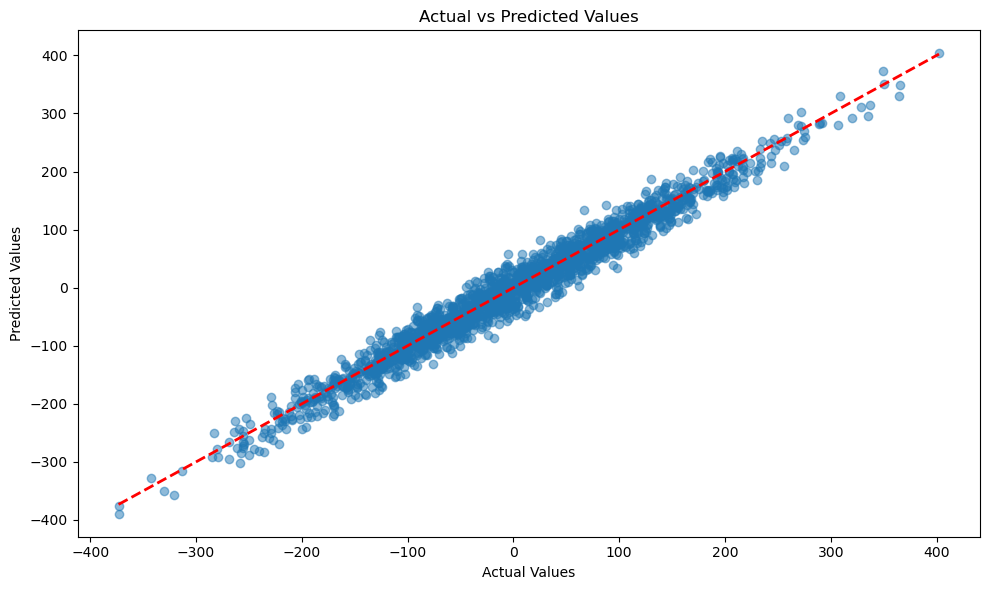

In [21]:
# 11. Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

---

# Using a List of Layer Syntax with `Sequential`


Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_layer_1 (Dense)           │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11162.9834 - mae: 83.5897 - val_loss: 742.8790 - val_mae: 21.2465
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 646.0489 - mae: 19.6220 - val_loss: 474.8950 - val_mae: 17.3478
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 495.6331 - mae: 17.6000 - val_loss: 447.1203 - val_mae: 16.7994
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 481.5585 - mae: 17.4568 - val_loss: 424.1072 - val_mae: 16.5126
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 447.7464 - mae: 16.8803 - val_loss: 401.2083 - val_mae: 16.0054
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 426.9507 - mae: 16.5290 - val_loss: 396.2438 - val_mae: 15.9225
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 412.4909 - mae: 16.1838 - val_loss: 393.7226 - val_mae: 15.8533
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 416.0050 - mae: 16.2052 - val_loss: 393.1324 - 

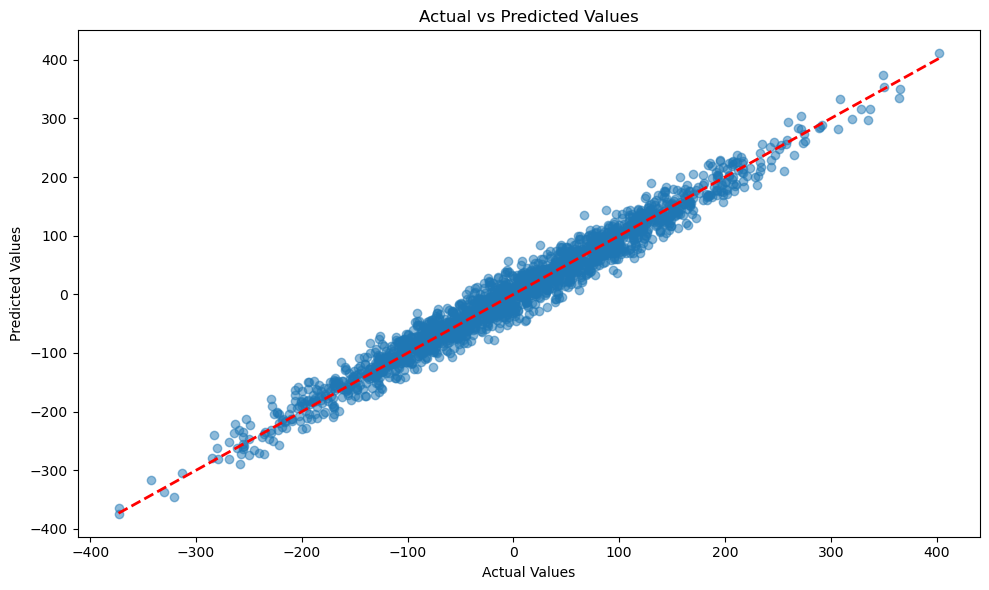

In [22]:
# 1. Create the input layer first
input_layer = Input(shape=(X_train.shape[1],), name='input_layer')

# 2. Create an empty sequential model
model = Sequential([
    # Start with the Input layer
    input_layer,
    
    # 3. First Dense Layer (previously called input layer)
    Dense(
        units=64,                     # Number of neurons in this layer
        activation='relu',            # Activation function
        name='dense_layer_1'          # Name to identify the layer
    ),
    
    # 4. First Hidden Layer
    Dense(
        units=32,                     # Number of neurons (smaller than previous layer)
        activation='relu',            # Same activation as before
        name='hidden_layer_1'         # Name for identification
    ),
    
    # 5. Second Hidden Layer
    Dense(
        units=16,                     # Even fewer neurons
        activation='relu',            # Same activation
        name='hidden_layer_2'         # Name for identification
    ),
    
    # 6. Output Layer
    Dense(
        units=1,                      # One neuron for regression
        activation=None,              # No activation for regression
        name='output_layer'           # Name for identification
    )
])

# 7. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with default learning rate
    loss='mean_squared_error',            # MSE loss for regression
    metrics=['mae']                       # Mean Absolute Error as additional metric
)

# 8. Print model summary to see the architecture
print("\nModel Architecture Summary:")
model.summary()

# 9. Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled,                    # Scaled input features
    y_train,                          # Target values (not scaled)
    epochs=50,                        # Number of training iterations
    batch_size=32,                    # Samples per training iteration
    validation_split=0.2,             # Use 20% of training data for validation
    verbose=1                         # Show training progress
)

# 10. Evaluate the model on test data
print("\nEvaluating the model on test data:")
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 11. Make predictions
predictions = model.predict(X_test_scaled)

# 12. Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

---

# Using Keras Functional API to Train Regression Model 

In [ ]:
# Create the Neural Network Model using Functional API
# -------------------------------------------------

"""
Step-by-step building of a neural network for regression using the Functional API.
This approach is more flexible and makes the model architecture more explicit.
"""

# 1. Import additional required module
from tensorflow.keras.models import Model

# 2. Define the Input layer
inputs = Input(shape=(X_train.shape[1],), name='input_layer')

# 3. Build the model layer by layer
# First Dense Layer
x = Dense(
    units=64,
    activation='relu',
    name='dense_layer_1'
)(inputs)

# First Hidden Layer
x = Dense(
    units=32,
    activation='relu',
    name='hidden_layer_1'
)(x)

# Second Hidden Layer
x = Dense(
    units=16,
    activation='relu',
    name='hidden_layer_2'
)(x)

# Output Layer
outputs = Dense(
    units=1,
    activation=None,
    name='output_layer'
)(x)

# 4. Create the model by specifying inputs and outputs
model = Model(inputs=inputs, outputs=outputs, name='regression_model')

# 5. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# 6. Print model summary
print("\nModel Architecture Summary:")
model.summary()

# 7. Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 8. Evaluate and visualize results
print("\nEvaluating the model on test data:")
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 9. Make predictions
predictions = model.predict(X_test_scaled)

# Let's also plot the training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual')

plt.tight_layout()
plt.show()